In [554]:
from sklearn import datasets, manifold
import random
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score as microsil
from sklearn.metrics import silhouette_samples

# K-Silhouette
* It labels the data based on the points with the maximum silhouette score in the cluster.
* All points are assigned a random integer label $k \in \{1, ..., K\}$.
* The point with the highest silhouette score per $k$ is extracted and used as a candidate center, so that all the points in the dataset will be assigned a label ($k$) according to their closest center.

In [574]:
# the method

def ksil(points, k, ssize=-1, max_iter=1000, patience=20):
    """K-Silhouette clustering of data by using the points with the maximum silhouette per cluster as centres

    :param points: the data
    :param k: the number of clusters
    :param ssize: the number of points to sample per cluster to evaluate silhouette, ignored by default
    :param max_iter: maximum number of iterations
    :param patience: number of epochs to wait with no improvement
    :return: the (best) centres, assigned labels, the history of the macro-score
    """
    
    size = len(points)
    stop, best_score, best_centres, best_clustering = 0, 0, [], []

    # Pick K centres at random
    centre_idx = np.random.choice(range(size), k, replace=False)
    centres = points[centre_idx]

    # The list of labels, random at start
    clustering = [np.random.randint(k) for i in range(size)]
    
    results = {'mean':[], 'sem':[]}
    
    # Define a convergence criterio and start
    for iteration in range(max_iter): 

        data = pd.DataFrame({'clustering': clustering, 
                             'points':points.tolist()})

        if ssize>0:
            # sample per cluster assignment (use the clustering of the previous iteration)
            cluster_samples = [] 
            for k_iter in range(k):
                cluster_points = data[data.clustering==k_iter] # fetch points in the k_iter cluster
                num_points = min(cluster_points.shape[0], ssize) # up to the min sample)size
                cluster_samples.append(cluster_points.sample(num_points))
            data = pd.concat(cluster_samples) # to dataframe
        
        # computing silhouette on the balanced space
        data_matrix = np.concatenate(data.points.apply(np.array).to_numpy()).reshape(data.shape[0], points.shape[1])
        data['silhouette'] = silhouette_samples(X=data_matrix, labels=data.clustering.values)
        
        # group all points per (previously-assigned) cluster
        sil_per_cluster = data.groupby('clustering').silhouette
        
        # find the points with the max sil (centres)
        centres = data.iloc[sil_per_cluster.apply(np.argmax).values]
                
        # assign all the points to their clusters based on the max_sil points
        new_assignments = [centres.points.apply(lambda x: np.linalg.norm(x-p)).argmin() for p in points]

        # proceed iff the solution makes sense
        if len(set(new_assignments)) != 1:
            
            # label re-assignment
            clustering = new_assignments                 
            
            # compute the macro-averaged silhouette score
            results['mean'].append(sil_per_cluster.apply(np.mean).mean())
            results['sem'].append(sil_per_cluster.apply(np.mean).sem())
                           
            # check a stopping criterion
            if results['mean'][-1] > best_score:
                best_score = results['mean'][-1]
                best_clustering = clustering
                best_centres = centres
                stop = 0
            else:
                stop+=1
            if stop>patience:
                print(f'Max patience is reached at K={len(set(clustering))}, using the solution with score {best_score:.2f}')
                return best_centres, best_clustering, pd.DataFrame(results)

    print(f'Maximum iterations are reached K={len(set(clustering))}, using the solution with score {best_score:.2f}')
    return best_centres, best_clustering, pd.DataFrame(results)

# The macro-averaged silhouette score
* Point-wise silhouette scores are computed and averaged per cluster
* The result should be averaged to compute the macro-average, but it can also be used to compute the standard error of the mean, as a measure of robustness across clusters.

In [575]:
def macrosil(X, clustering):
    point_sils = pd.DataFrame({'sil': silhouette_samples(X, clustering), 'label':clustering})
    return point_sils.groupby('label').sil.apply(np.mean)

# Experiments: Digits
* The [handwritten digits](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits) dataset.
* 5,620 images, each with 64 features (multivariate), and one label (the depicted integer).

In [576]:
# dataset loading (digits)
digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

Max patience is reached at K=4, using the solution with score 0.12


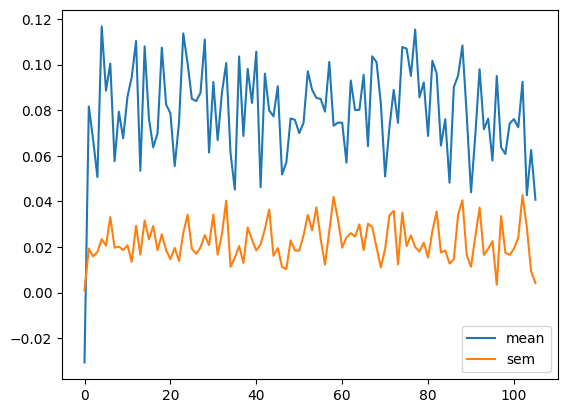

In [577]:
centres, clustering, history = ksil(points=X, k=20, patience=100)
history.plot();

In [578]:
print(f'Micro-Sil: {microsil(X, clustering):.2f}')
print(f'Macro-Sil: {macrosil(X, clustering).mean():.2f}')

Micro-Sil: 0.09
Macro-Sil: 0.09


The BASELINE

In [555]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X)
print(f'Micro-Sil: {microsil(X, kmeans.labels_):.2f}')
print(f'Macro-Sil: {macrosil(X, kmeans.labels_).mean():.2f}')

Micro-Sil: 0.18
Macro-Sil: 0.19
